# Exercise #1: Building an inverted index

  - You are given a sample (1000 documents) from the [The Reuters-21578 data collection](http://www.daviddlewis.com/resources/testcollections/reuters21578/) in `data/reuters21578-000.xml`
  - The code that parses the XML and extract a list of preprocessed terms (tokenized, lowercased, stopwords removed) is already given
  - You are also given an `InvertedIndex` class that manages the posting lists operations
  - Your tasks will include:
    1. Creating a unit test for the indexing class
    2. Building an inverted index from the input collection
    3. Using NLTK for text preprocessing
    4. Including bigrams as well in the index

In [1]:
from xml.dom import minidom
from collections import Counter
import re

## Parsing documents

Stopwords list

In [2]:
STOPWORDS = ["a", "an", "and", "are", "as", "at", "be", "but", "by", "for", "if", "in", "into", "is", "it", "no", "not", "of", "on", "or", "such", "that", "the", "their", "then", "there", "these", "they", "this", "to", "was", "will", "with"]

Stripping tags inside <> using regex

In [3]:
def striptags(text):
    p = re.compile(r'<.*?>')
    return p.sub('', text)

Parse input text and return a list of indexable terms

In [4]:
def parse(text):
    terms = []
    # Replace specific characters with space
    chars = ["'", ".", ":", ",", "!", "?", "(", ")"]
    for ch in chars:
        if ch in text:
            text = text.replace(ch, " ")

    # Remove tags
    text = striptags(text)

    # Tokenization
    for term in text.split():  # default behavior of the split is to split on one or more whitespaces
        # Lowercasing
        term = term.lower()
        # Stopword removal
        if term in STOPWORDS:
            continue
        terms.append(term)

    return terms

## Processing the input document collection

  - The collection is given as a single XML file. 
  - Each document is inside `<REUTERS ...> </REUTERS>`.
  - We extract the contents of the `<DATE>`, `<TITLE>`, and `<BODY>` tags.
  - After each extracted document, the provided callback function is called and all document data is passed in a single dict argument.

In [5]:
def process_collection(input_file, callback):
    xmldoc = minidom.parse(input_file)
    # Iterate documents in the XML file
    itemlist = xmldoc.getElementsByTagName("REUTERS")
    doc_id = 0
    for doc in itemlist:
        doc_id += 1
        date = doc.getElementsByTagName("DATE")[0].firstChild.nodeValue
        # Skip documents without a title or body
        if not (doc.getElementsByTagName("TITLE") and doc.getElementsByTagName("BODY")):
            continue
        title = doc.getElementsByTagName("TITLE")[0].firstChild.nodeValue
        body = doc.getElementsByTagName("BODY")[0].firstChild.nodeValue
        callback({
            "doc_id": doc_id,
            "date": date,
            "title": title,
            "body": body
            })

Prints a document's contents (used as a callback function passed to `process_collection`)

In [40]:
def print_doc(doc):
    if doc["doc_id"] <= 5:  # print only the first 5 documents
        print("docID:", doc["doc_id"])
        print("date:", doc["date"])
        print("title:", doc["title"])
        print("body:", doc["body"])
        print("--")

In [41]:
process_collection("data/reuters21578-000.xml", print_doc)

docID: 1
date: 26-FEB-1987 15:01:01.79
title: BAHIA COCOA REVIEW
body: Showers continued throughout the week in
the Bahia cocoa zone, alleviating the drought since early
January and improving prospects for the coming temporao,
although normal humidity levels have not been restored,
Comissaria Smith said in its weekly review.
    The dry period means the temporao will be late this year.
    Arrivals for the week ended February 22 were 155,221 bags
of 60 kilos making a cumulative total for the season of 5.93
mln against 5.81 at the same stage last year. Again it seems
that cocoa delivered earlier on consignment was included in the
arrivals figures.
    Comissaria Smith said there is still some doubt as to how
much old crop cocoa is still available as harvesting has
practically come to an end. With total Bahia crop estimates
around 6.4 mln bags and sales standing at almost 6.2 mln there
are a few hundred thousand bags still in the hands of farmers,
middlemen, exporters and processors.
   

## Inverted index

  - The inverted index is an object with methods for adding and fetching postings.
  - The data is stored in a map, where keys are terms and values are lists of postings.
  - Each posting is an object that holds the doc_id and an optional payload.

In [12]:
class Posting(object):
    def __init__(self, doc_id, payload=None):
        self.doc_id = doc_id
        self.payload = payload
    
    def get_doc_id(self):
        return self.doc_id
    
    def get_payload(self):
        return self.payload

In [21]:
class InvertedIndex(object):

    def __init__(self):
        self.index = {}
    
    def add_posting(self, term, doc_id, payload=None):
        """Adds a document to the posting list of a term."""
        if term not in self.index:  # if term not in index, initialize empty posting list
            self.index[term] = []
        # append new posting to the posting list
        self.index[term].append(Posting(doc_id, payload))

    def get_postings(self, term):
        """Fetches the posting list for a given term."""
        if term in self.index:
            return self.index[term]
        return None

    def get_terms(self):
        """Returns all unique terms in the index."""
        return self.index.keys() 
    
    def write_to_file(self, filename_index):
        """Saves the index to a textfile."""
        f = open(filename_index, "w")
        for term, postings in self.index.items():
            f.write(term)
            for posting in postings:
                f.write(" " + str(posting.doc_id))
                if posting.payload is not None:
                    f.write(":" + str(posting.payload))
            f.write("\n")
        f.close()    

## Task 1: Create a unit test

**TODO**: Complete the two tests.

In [23]:
import unittest

class TestInvertedIndex(unittest.TestCase):

    def test_postings(self):
        ind = InvertedIndex()
        ind.add_posting("term", 1, 1)
        ind.add_posting("term", 2, 4)
        # Testing existing term
        postings = ind.get_postings("term")
        self.assertEqual(len(postings), 2)
        self.assertEqual(postings[0].get_doc_id(), 1)
        self.assertEqual(postings[0].get_payload(), 1)
        self.assertEqual(postings[1].get_doc_id(), 2)
        self.assertEqual(postings[1].get_payload(), 4)            
        # Testing non-existent term
        self.assertEqual(ind.get_postings("xyx"), None)

    def test_vocabulary(self):
        ind = InvertedIndex()
        ind.add_posting("term1", 1)
        ind.add_posting("term2", 1)
        ind.add_posting("term3", 2)
        ind.add_posting("term2", 3)
        self.assertEqual(ind.get_terms(), set(["term1", "term2", "term3"]))
        
        
unittest.main(argv=['-q', 'TestInvertedIndex'], verbosity=2, exit=False)

test_postings (__main__.TestInvertedIndex) ... ok
test_vocabulary (__main__.TestInvertedIndex) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


## Task 2: Build an inverted index from the input collection

**TODO**: Complete the code to index the entire document collection.  (The content for each document is the title and body concatenated)

In [22]:
ind = InvertedIndex()

def index_doc(doc):
    text = doc["title"] + " " + doc["body"]
    terms = parse(text)  # list of terms in the document
    tc = Counter(terms)  # dict with term counts
    for term, freq in tc.items():
        ind.add_posting(term, doc["doc_id"], freq)
    
process_collection("data/reuters21578-000.xml", index_doc)

**TODO**: Save the inverted index to a file (`data/index.dat`). You may use a simple text file, e.g., with `termID docID1:freq1 docID2:freq2 ...` per line. 

Implement this by (1) adding a `write_to_file(self, filename)` method to the `InvertedIndex` class and then (2) invoking that method in the cell below.

In [24]:
ind.write_to_file("data/index.dat")

**TODO (advanced, optional)**: Create a plot that compares the size of the document collection (bytes) against the size of the corresponding index (bytes) on the y-axis vs. with respect to the number of documents on the x-axis. You may use [Matplotlib](https://www.tutorialspoint.com/jupyter/jupyter_notebook_plotting.htm) for plotting.

We write a different callback function and use that one for indexing

In [48]:
import sys
import os

ind = InvertedIndex()
tmp_file = "data/index_tmp.dat"
stats = {
    'num_docs': 0,
    'sum_bytes': 0,
    'size_index': [],
    'size_docs': []
}

def index_doc_with_stats(doc):
    index_doc(doc)
    # Stats are stored in a global variable (not very elegant but quick solution)
    stats['num_docs'] += 1
    stats['sum_bytes'] += sys.getsizeof(str(doc))  # string document representation is a good proxy for doc size
    # We measure index size and document collection size after every 100 docs
    if stats['num_docs'] % 100 == 0:        
        stats['size_docs'].append(stats['sum_bytes'])
        # To get index size, we dump it to a file and get file size
        # Alternatively, use the pympler package to measure the size of Python objects
        ind.write_to_file(tmp_file)
        stats['size_index'].append(os.path.getsize(tmp_file))
        

process_collection("data/reuters21578-000.xml", index_doc_with_stats)

This line is needed to render plots inline in Jupyter notebooks

In [25]:
%matplotlib inline

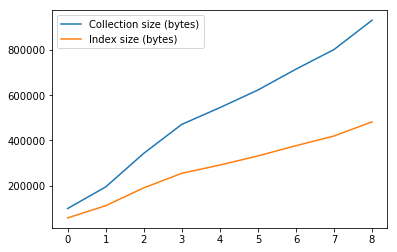

In [57]:
import matplotlib.pyplot as plt
plt.plot(stats['size_docs'], label="Collection size (bytes)")
plt.plot(stats['size_index'], label="Index size (bytes)")
plt.legend(loc='upper left')

## Task 3: Use NLTK for text preprocessing

**TODO**: Perprocess the text using the [tokenizer](http://www.nltk.org/howto/tokenize.html) and [Porter stemmer](http://www.nltk.org/howto/stem.html) in NLTK, but use the same stopwords list as before (i.e., defined in the `STOPWORDS` variable).

In [ ]:
# TODO

**TODO**: Build the index and save it to a file (`data/index_nltk.dat`).

In [ ]:
# TODO

**TODO**: Compare the first 10 words of the vocabulary using our simple text preprocessing methods (from Task 2) versus the vocabulary when using NLTK (Task 3)

In [ ]:
# TODO

## Task 4 (advanced, optional): Include bigrams in the index

**TODO**: Create an index using bigrams, instead of unigrams. Hint: you may want to look at [some possible usages](https://www.programcreek.com/python/example/86315/nltk.bigrams) of [`nltk.util.bigrams()`](http://www.nltk.org/api/nltk.html#nltk.util.bigrams).  

In [ ]:
# TODO

**TODO**: Build the index and save it to a file (`data/index_nltk_bigrams.dat`).

In [ ]:
# TODO

**TODO**: How does the size of the vocabulary compare against using only unigrams (i.e., the index from Task 3)?

In [ ]:
# TODO

## Feedback

Please give (anonymous) feedback on this exercise by filling out [this form](https://forms.gle/22o3ursi5YsR1Ztb8).